Importing modules

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

Data Cleaning Pipeline

In [35]:
#insert data pipeline here

Preliminary data analysis: selecting the locations of interest
NB: This data contains the breweries and beers defined by country excluding the US which is further separated by US states

In [36]:
#number of beers per location
breweries = pd.read_csv('minimizedData/BA_breweries_small.csv')

In [37]:
#Calculating the number of beers and breweries produced by each location
country_stats = breweries.groupby('location').agg(
    total_breweries=('id', 'nunique'),
    total_beers=('nbr_beers', 'sum')
).reset_index()

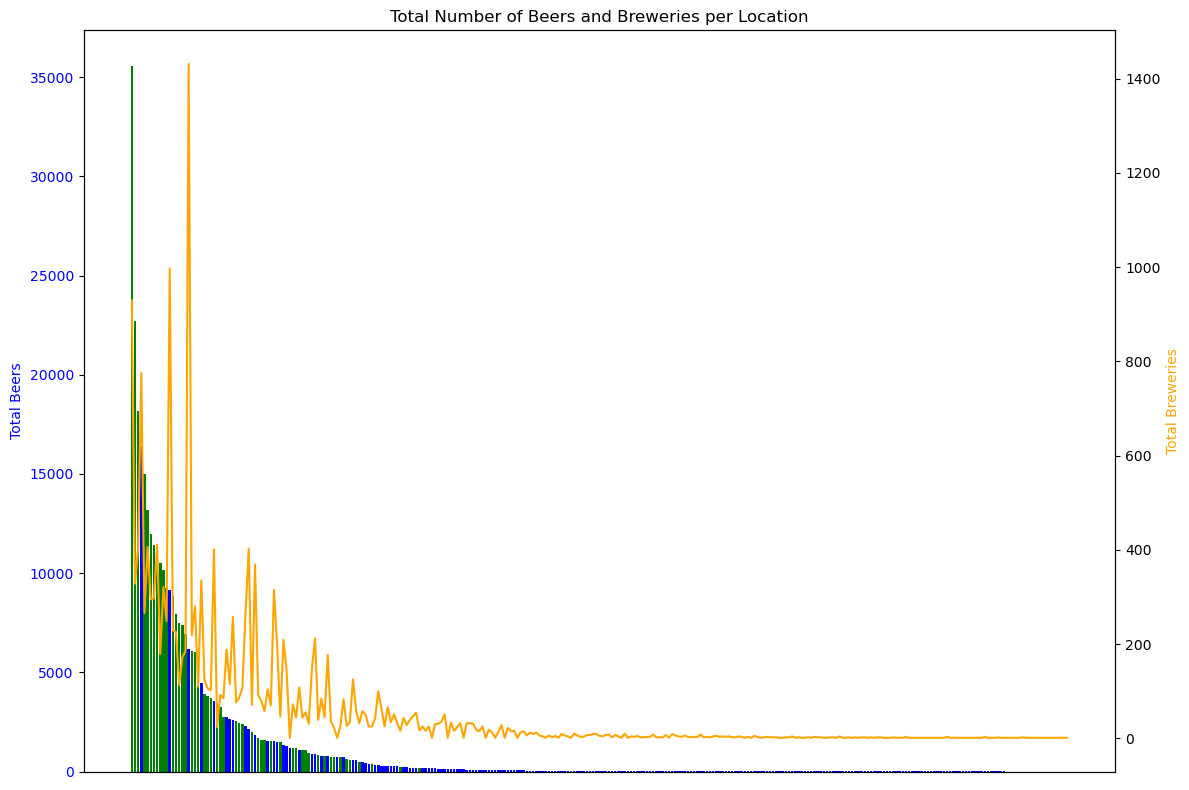

In [38]:
# Plotting the total number of beers and breweries for each location

country_stats = country_stats.sort_values(by='total_beers', ascending=False)
fig, ax1 = plt.subplots(figsize=(12, 8))

bar_colors = ['green' if country.startswith('United States,') else 'blue' for country in country_stats['location']]

# Bar plot for total beers
ax1.bar(country_stats['location'], country_stats['total_beers'], color=bar_colors, label='Total Beers')
#ax1.set_xlabel('Country')
ax1.set_ylabel('Total Beers', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.xticks([])

#Overlay line plot for total breweries
ax2 = ax1.twinx()
ax2.plot(country_stats['location'], country_stats['total_breweries'], color='orange', label='Total Breweries')
ax2.set_ylabel('Total Breweries', color='orange')
plt.xticks([])

plt.title('Total Number of Beers and Breweries per Location')
fig.tight_layout()
plt.show()


In the figure above the green locations are US states and the blue represent all other countriess

The distribution of users by location of origin

In [39]:
users = pd.read_csv('minimizedData/BA_users_small.csv')
print("Quick stats on the users")
print("total number of users:", users.shape[0])
#Remove users with unknown locations
users = users.dropna(subset=['location'])
print("Number of users with known locations:", users.shape[0])
print("Users originate from: ",users['location'].dropna().nunique() , "different locations")

Quick stats on the users
total number of users: 153704
Number of users with known locations: 122425
Users originate from:  194 different locations


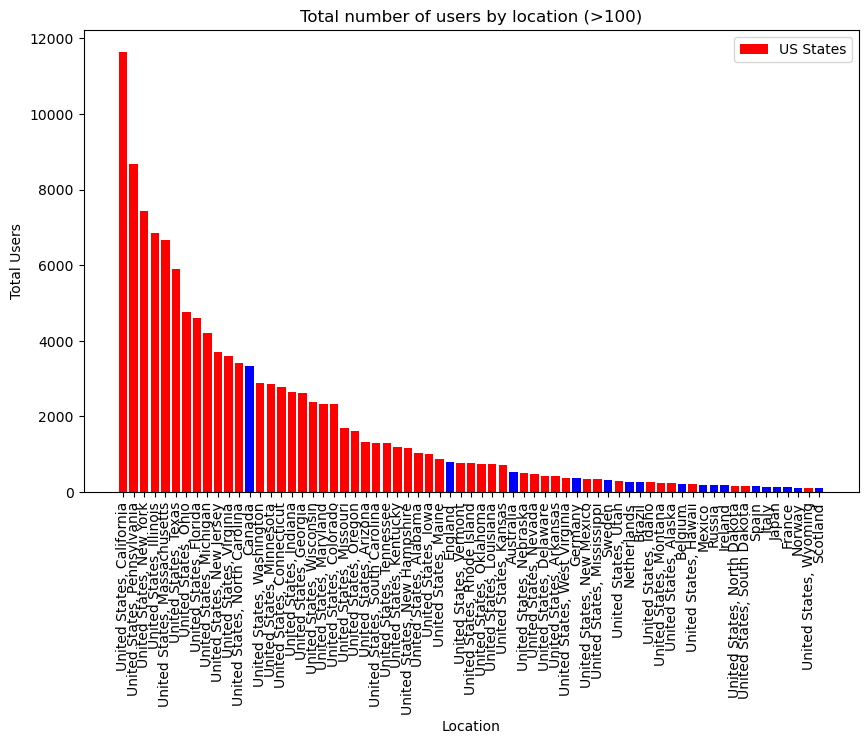

In [40]:
#plotting user location distributions
user_counts = users.groupby('location').size().reset_index(name='total_users')
user_counts = user_counts[user_counts['total_users'] >= 100]
user_counts = user_counts.sort_values(by='total_users', ascending=False)
user_counts['color'] = user_counts['location'].apply(lambda x: 'red' if x.startswith('United States,') else 'blue')
plt.figure(figsize=(10, 6))
plt.bar(user_counts['location'], user_counts['total_users'], color=user_counts['color'], )
plt.xlabel('Location')
plt.ylabel('Total Users')

plt.legend(['US States'], loc="upper right")
plt.title('Total number of users by location (>100)')
plt.xticks(rotation=90)

plt.show()


In [41]:
BA_merged = pd.read_csv('minimizedData/BA_ratings_small_plus.csv')
BA_merged_cleaned = BA_merged[BA_merged['user_location'].notna()]
BA_merged_cleaned = BA_merged[BA_merged['beer_location'].notna()]

#Local reviews (reviews written by people from one country reviewing beers from that same location)
local_reviews = BA_merged_cleaned[BA_merged_cleaned['user_location'] == BA_merged_cleaned['beer_location']].groupby('beer_location').size().reset_index(name='local_reviews')

#Non-local reviews (reviews written by people for beers from other location)
non_local_reviews = BA_merged_cleaned[BA_merged_cleaned['user_location'] != BA_merged_cleaned['beer_location']].groupby('beer_location').size().reset_index(name='non_local_reviews')

#Total number of beers per country from the 'country_stats' DataFrame
country_stats = breweries.groupby('location').agg(
    total_breweries=('id', 'nunique'),  # Count of unique breweries per country
    total_beers=('nbr_beers', 'sum')  # Sum of beers per country
).reset_index()

country_data = pd.merge(country_stats, local_reviews, left_on='location', right_on='beer_location', how='left')
country_data = pd.merge(country_data, non_local_reviews, left_on='location', right_on='beer_location', how='left')

#Fill NaN values with 0 for countries with no reviews in any category
country_data[['local_reviews', 'non_local_reviews']] = country_data[['local_reviews', 'non_local_reviews']].fillna(0)

#Sort the DataFrame by the total number of local reviews in ascending order
country_data = country_data.sort_values(by='local_reviews', ascending=False)




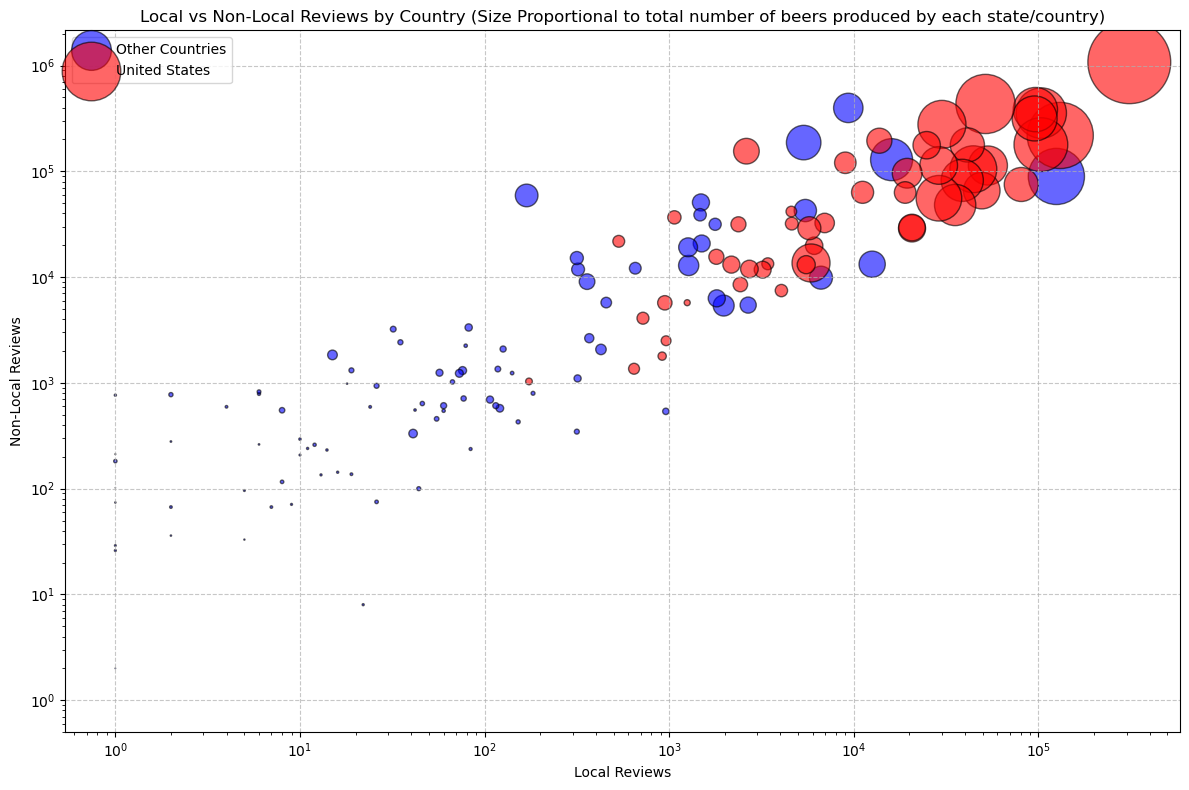

In [42]:

fig, ax = plt.subplots(figsize=(12, 8))

#Identify states that are in the US
highlighted = country_data['location'].str.startswith('United States')

#Plot for countries that are NOT 'United States' in blue
scatter = ax.scatter(
    country_data.loc[~highlighted, 'local_reviews'],
    country_data.loc[~highlighted, 'non_local_reviews'],
    s=country_data.loc[~highlighted, 'total_beers'] * 0.1,
    color='blue', 
    alpha=0.6,
    edgecolor='black',
    label='Other Countries'
)

#Plot for US states in red
scatter_us = ax.scatter(
    country_data.loc[highlighted, 'local_reviews'],
    country_data.loc[highlighted, 'non_local_reviews'],
    s=country_data.loc[highlighted, 'total_beers'] * 0.1,
    color='red',
    alpha=0.6,
    edgecolor='black',
    label='United States'
)

# Set plot labels and title
ax.set_xlabel('Local Reviews')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Non-Local Reviews')
ax.set_title('Local vs Non-Local Reviews by Country (Size Proportional to total number of beers produced by each state/country)')
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()


The number of beers produced by each location is proportional to the number of both local and non local reviews. We can see directly from the graphics that the US states as a substantial number of data points when looking at the number of beer produced, the number of reviews as well as the origin of the users. Therefore we will be restricting our analysis to the US states. Furthermore the distributions for all of these considerations decrease substantially for the countries on the lower end of the scale which is not interesting to us since we would not have enough data to analyse.

In [43]:
#DATA pipeline for the US data only acces

print(BA_merged.shape)
US_ratings = BA_merged.dropna(subset=['beer_location','user_location','rating'])
print(US_ratings.shape)
#we are only interested in focusing on the ratings that originate from US users AND are for US beers
US_ratings = US_ratings[US_ratings['user_location'].str.startswith('United States,')]
US_ratings = US_ratings[US_ratings['beer_location'].str.startswith('United States,')]

US_ratings.head(2)

(8393032, 16)
(7892754, 16)


,Unnamed: 0,beer_name,beer_id,brewery_name,brewery_id,style,user_id,appearance,aroma,palate,taste,overall,rating,user_location,avg,beer_location
1008809,1008809,Kupfer Kolsch,289320.0,Copper State Brewing Company,49595.0,Kölsch,n2185.211743,2.5,4.00,4.0,3.75,3.75,3.76,"United States, North Carolina",3.76,"United States, Wisconsin"
1008810,1008810,Northwestern Alt,289321.0,Copper State Brewing Company,49595.0,Altbier,n2185.211743,3.0,3.75,4.0,3.50,3.50,3.58,"United States, North Carolina",3.58,"United States, Wisconsin"


In [44]:
#removing the United States part from the location for both beer and user for clarity
US_ratings['user_state'] = US_ratings['user_location'].apply(lambda x: x.split(',')[1].strip())
US_ratings['beer_state'] = US_ratings['beer_location'].apply(lambda x: x.split(',')[1].strip())
US_ratings = US_ratings.drop(['user_location','beer_location'], axis=1)

US_ratings = US_ratings[(US_ratings['user_state'] != 'United States') & (US_ratings['beer_state'] != 'United States')]


Q1

Q2

Q3: State Specific analysis of in state and out state reviews

In [49]:
#US_data pipepline
print(BA_merged.shape)
US_ratings = BA_merged.dropna(subset=['beer_location','user_location','rating'])
print("Dropping ratings that have no beer locations, user locations and ratings ")
print(US_ratings.shape)
#we are only interested in focusing on the ratings that originate from US users AND are for US beers
US_ratings = US_ratings[US_ratings['user_location'].str.startswith('United States,')]
US_ratings = US_ratings[US_ratings['beer_location'].str.startswith('United States,')]



#removing the United States part from the location for both beer and user for clarity
US_ratings['user_state'] = US_ratings['user_location'].apply(lambda x: x.split(',')[1].strip())
US_ratings['beer_state'] = US_ratings['beer_location'].apply(lambda x: x.split(',')[1].strip())
US_ratings = US_ratings.drop(['user_location','beer_location'], axis=1)

US_ratings = US_ratings[(US_ratings['user_state'] != 'United States') & (US_ratings['beer_state'] != 'United States')]


(8393032, 16)
Dropping ratings that have no beer locations, user locations and ratings 
(7892754, 16)


In [50]:
#Average rating of all users by state for all states
#Mean calculated by grouping rankings by user_state and beer_state
state_ratings = US_ratings.groupby(['user_state', 'beer_state'])['avg'].mean().reset_index()

In [51]:
#create matrix which gives the avg rating of each beers of state to user of state combination pair
#ratings_matrix = state_ratings.pivot_table(index='user_state', columns='beer_state', values='avg')
state_ratings_matrix = state_ratings.pivot_table(index='user_state', columns='beer_state', values='avg', fill_value=0)

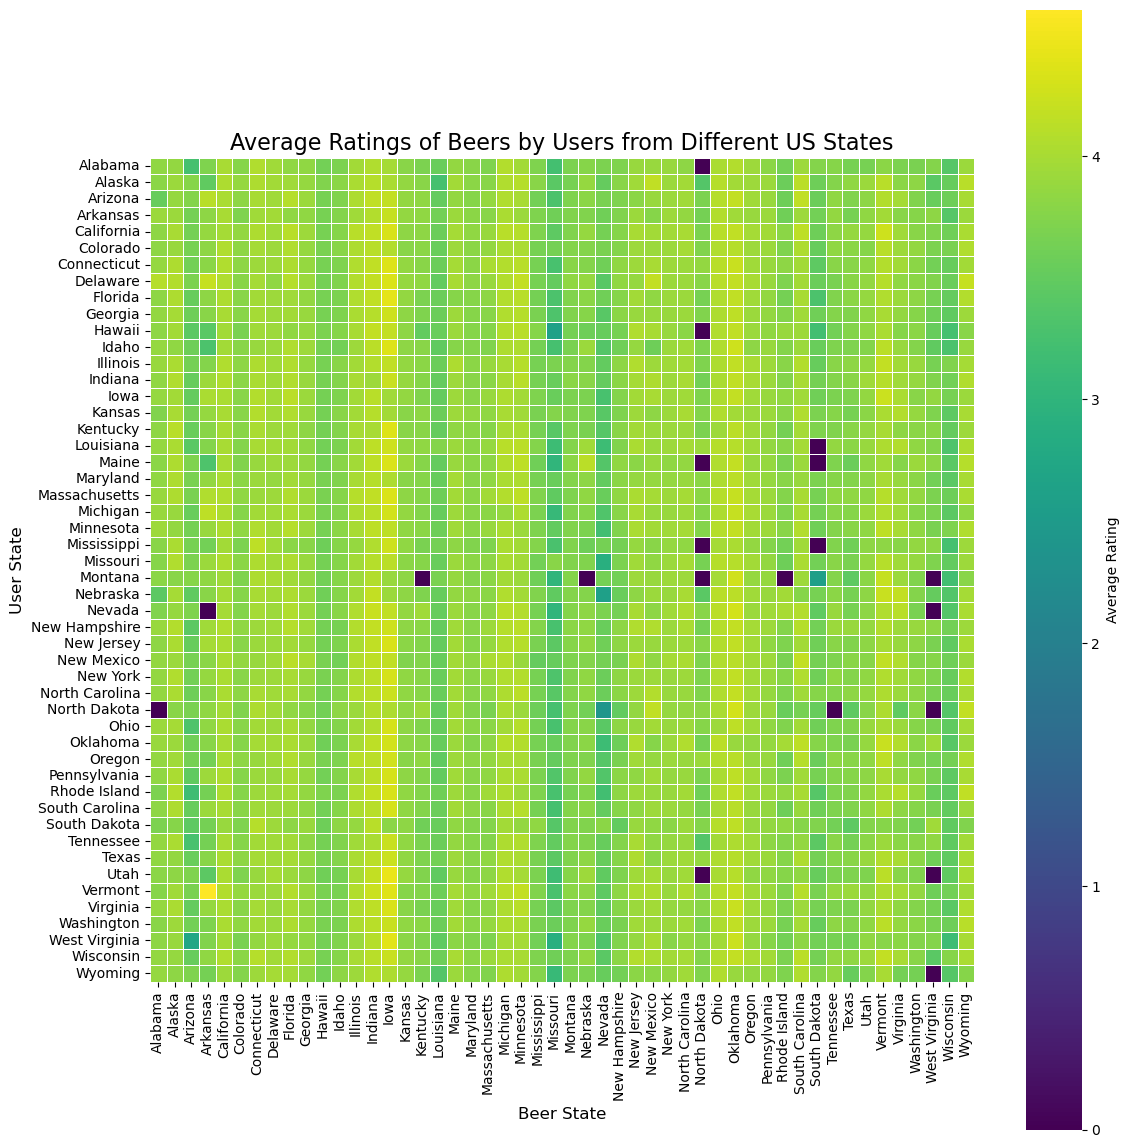

In [52]:
plt.figure(figsize=(12, 12))

sns.heatmap(state_ratings_matrix, annot=False, fmt=".2f", cmap='viridis', linewidths=0.5, cbar_kws={'label': 'Average Rating'}, square=True)

plt.title('Average Ratings of Beers by Users from Different US States', fontsize=16)
plt.xlabel('Beer State', fontsize=12)
plt.ylabel('User State', fontsize=12)
plt.tight_layout()

plt.show()


In [53]:
#average ratings for each state when rating its own beer
own_beer_ratings = US_ratings[US_ratings['user_state'] == US_ratings['beer_state']].groupby('beer_state')['avg'].mean()

#total number of ratings per beer_state
total_ratings_per_state = US_ratings.groupby('beer_state').size()

#weighted average rating for each beer by other states
other_state_ratings = US_ratings[US_ratings['user_state'] != US_ratings['beer_state']]
other_state_avg_ratings = other_state_ratings.groupby('beer_state').apply(
    lambda group: np.average(group['rating'], weights=group['user_state'].map(total_ratings_per_state))
)

ratings_comparison = pd.DataFrame({
    'own_beer_avg': own_beer_ratings,
    'other_states_avg': other_state_avg_ratings
})

ratings_comparison['other_states_avg'] = ratings_comparison['other_states_avg'].fillna(0)

C:\Users\iaran\AppData\Local\Temp\ipykernel_14960\2543180676.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  other_state_avg_ratings = other_state_ratings.groupby('beer_state').apply(


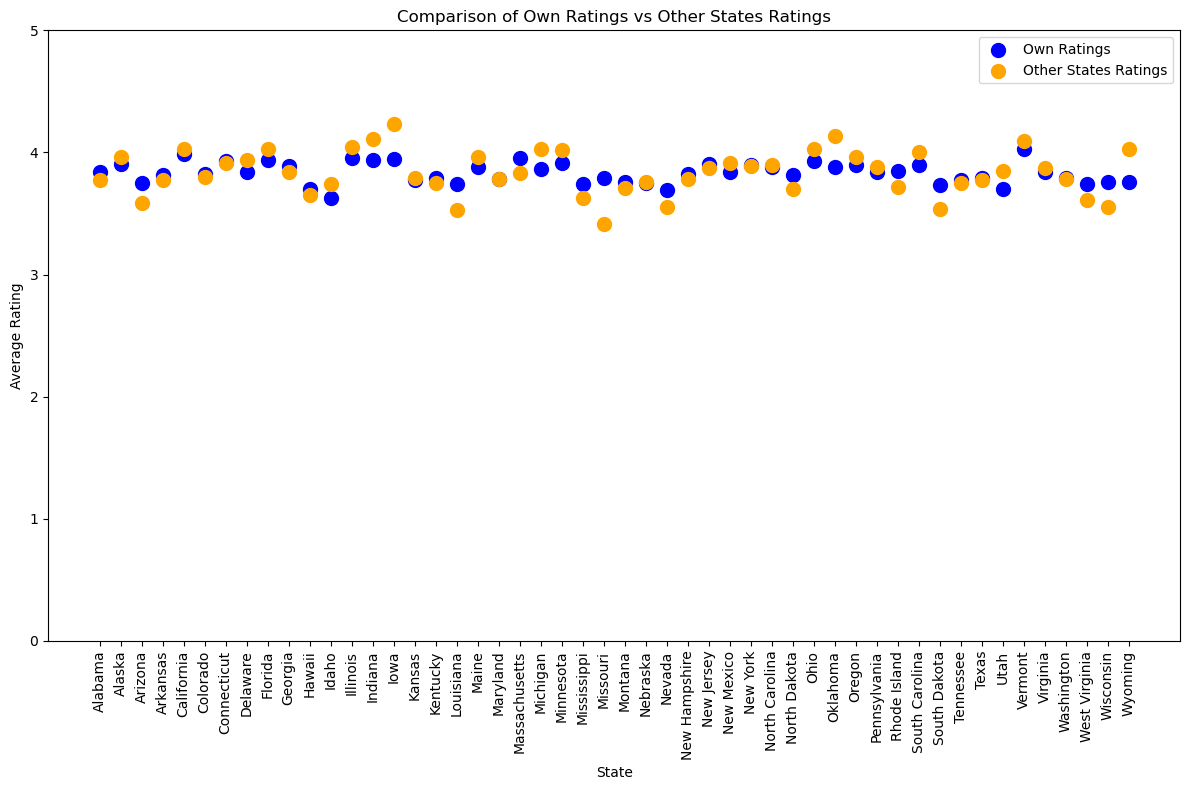

In [55]:
plt.figure(figsize=(12, 8))

plt.scatter(ratings_comparison.index, ratings_comparison['own_beer_avg'], label='Own Ratings', color='blue', s=100, zorder=2)
plt.scatter(ratings_comparison.index, ratings_comparison['other_states_avg'], label='Other States Ratings', color='orange', s=100, zorder=2)


plt.xlabel('State')
plt.ylabel('Average Rating')
plt.title('Comparison of Own Ratings vs Other States Ratings')
plt.xticks(rotation=90)
plt.ylim(0,5)
plt.legend()
plt.tight_layout()

plt.show()


C:\Users\iaran\AppData\Local\Temp\ipykernel_14960\4153175424.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


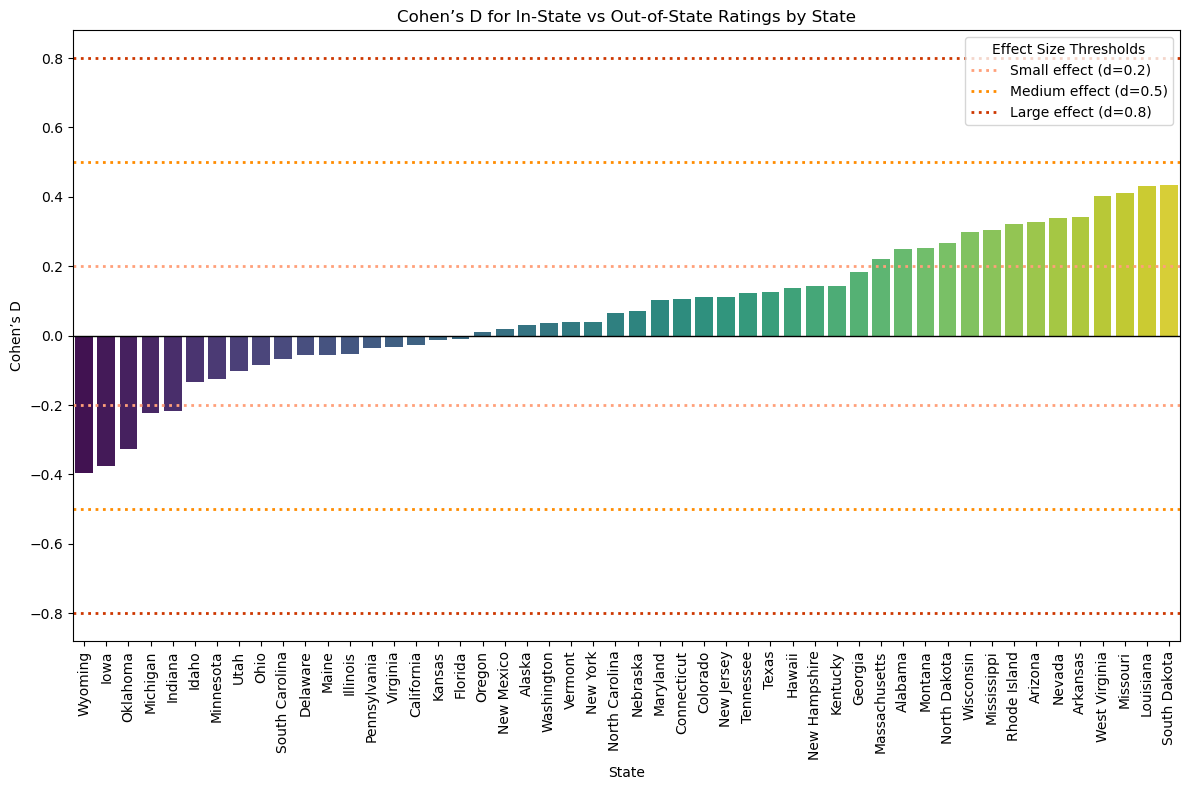

In [60]:
def cohen_d(x, y):
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    nx, ny = len(x), len(y)
    mean_x, mean_y = np.mean(x), np.mean(y)
    std_x, std_y = np.std(x, ddof=1), np.std(y, ddof=1) 
    pooled_std = np.sqrt(((nx - 1) * std_x ** 2 + (ny - 1) * std_y ** 2) / (nx + ny - 2))
    return (mean_x - mean_y) / pooled_std

unique_states = US_ratings['beer_state'].unique()
unique_states.sort()

cohen_results = {}

for state in unique_states:
    subset = US_ratings[US_ratings['beer_state'] == state]
    in_state_ratings = subset[subset['state_IN_VS_OUT'] == 'In-State']['rating']
    out_of_state_ratings = subset[subset['state_IN_VS_OUT'] == 'Out-of-State']['rating']
    
    if len(in_state_ratings) == 0 or len(out_of_state_ratings) == 0:
        cohen_results[state] = np.nan
        continue
    
    d_value = cohen_d(in_state_ratings, out_of_state_ratings)
    cohen_results[state] = d_value

cohen_df = pd.DataFrame.from_dict(cohen_results, orient='index', columns=['Cohen_d'])
cohen_df.sort_values(by='Cohen_d', inplace=True)  # Optional: sort by Cohen's D value

cohen_df_no_nan = cohen_df.dropna()

plt.figure(figsize=(12, 8))

sns.barplot(
    x=cohen_df_no_nan.index, 
    y='Cohen_d', 
    data=cohen_df_no_nan, 
    palette='viridis'
)

plt.axhline(y=0, color='black', linewidth=1)

plt.axhline(y=0.2, color='#FFA07A', linestyle=':', linewidth=2, label='Small effect (d=0.2)')
plt.axhline(y=-0.2, color='#FFA07A', linestyle=':', linewidth=2)
plt.axhline(y=0.5, color='#FF8C00', linestyle=':', linewidth=2, label='Medium effect (d=0.5)')
plt.axhline(y=-0.5, color='#FF8C00', linestyle=':', linewidth=2)
plt.axhline(y=0.8, color='#CD3700', linestyle=':', linewidth=2, label='Large effect (d=0.8)')
plt.axhline(y=-0.8, color='#CD3700', linestyle=':', linewidth=2)

plt.xlabel('State')
plt.ylabel('Cohen’s D')
plt.title('Cohen’s D for In-State vs Out-of-State Ratings by State')

plt.xticks(rotation=90)

plt.legend(title='Effect Size Thresholds', loc='upper right')

plt.tight_layout()
plt.show()

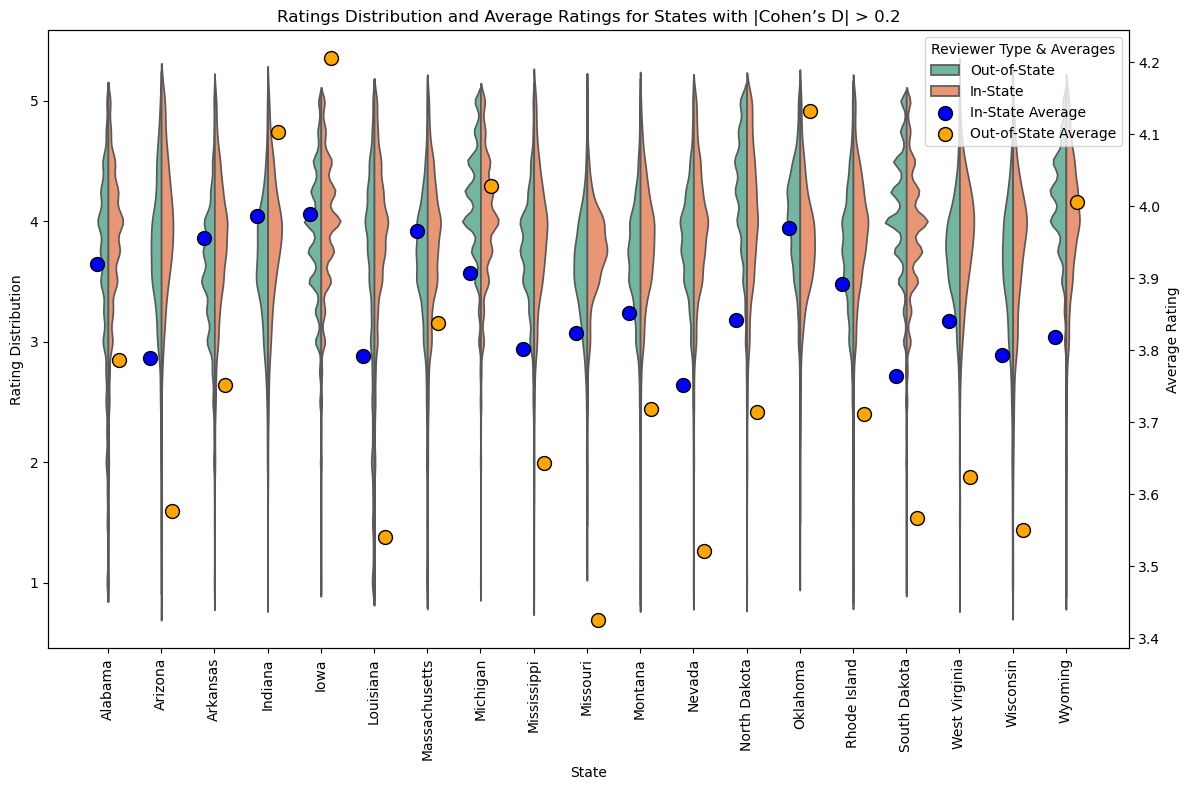

In [61]:
significant_states = cohen_df_no_nan[
    (cohen_df_no_nan['Cohen_d'] > 0.2) | (cohen_df_no_nan['Cohen_d'] < -0.2)
].index
significant_states = sorted(significant_states)

filtered_ratings = US_ratings[US_ratings['beer_state'].isin(significant_states)]

average_ratings = filtered_ratings.groupby(['beer_state', 'state_IN_VS_OUT'])['rating'].mean().reset_index()

plt.figure(figsize=(12, 8))

ax1 = sns.violinplot(
    x='beer_state', 
    y='rating', 
    hue='state_IN_VS_OUT', 
    data=filtered_ratings, 
    split=True, 
    inner=None, 
    palette='Set2'
)

ax1.legend_.remove()

ax1.set_xlabel('State')
ax1.set_ylabel('Rating Distribution')
ax1.set_title('Ratings Distribution and Average Ratings for States with |Cohen’s D| > 0.2')

ax2 = ax1.twinx()

colors = {'In-State': 'blue', 'Out-of-State': 'orange'}

labels_added = set()  

for i, state in enumerate(significant_states):
    state_avg_ratings = average_ratings[average_ratings['beer_state'] == state]
    
    for relation, color in colors.items():
        avg_value = state_avg_ratings[state_avg_ratings['state_IN_VS_OUT'] == relation]['rating']
        if not avg_value.empty:
            x_pos = i  # Position at the state's index
            offset = -0.2 if relation == 'In-State' else 0.2
            label = f'{relation} Average' if f'{relation} Average' not in labels_added else None
            
            ax2.scatter(x_pos + offset, avg_value, 
                        color=color, 
                        edgecolor='black', 
                        s=100, 
                        zorder=3, 
                        label=label)
            if label is not None:
                labels_added.add(label)

ax2.set_ylabel('Average Rating')

ax1.set_xticks(range(len(significant_states)))  
ax1.set_xticklabels(significant_states, rotation=90)  

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

lines_combined, labels_combined = [], []
for l, la in zip(lines_1 + lines_2, labels_1 + labels_2):
    if la not in labels_combined:
        lines_combined.append(l)
        labels_combined.append(la)

ax1.legend(lines_combined, labels_combined, title='Reviewer Type & Averages', loc='upper right')

plt.tight_layout()
plt.show()


C:\Users\iaran\AppData\Local\Temp\ipykernel_14960\2191283091.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=state_results, y='state', x='difference', palette='coolwarm', orient='h')


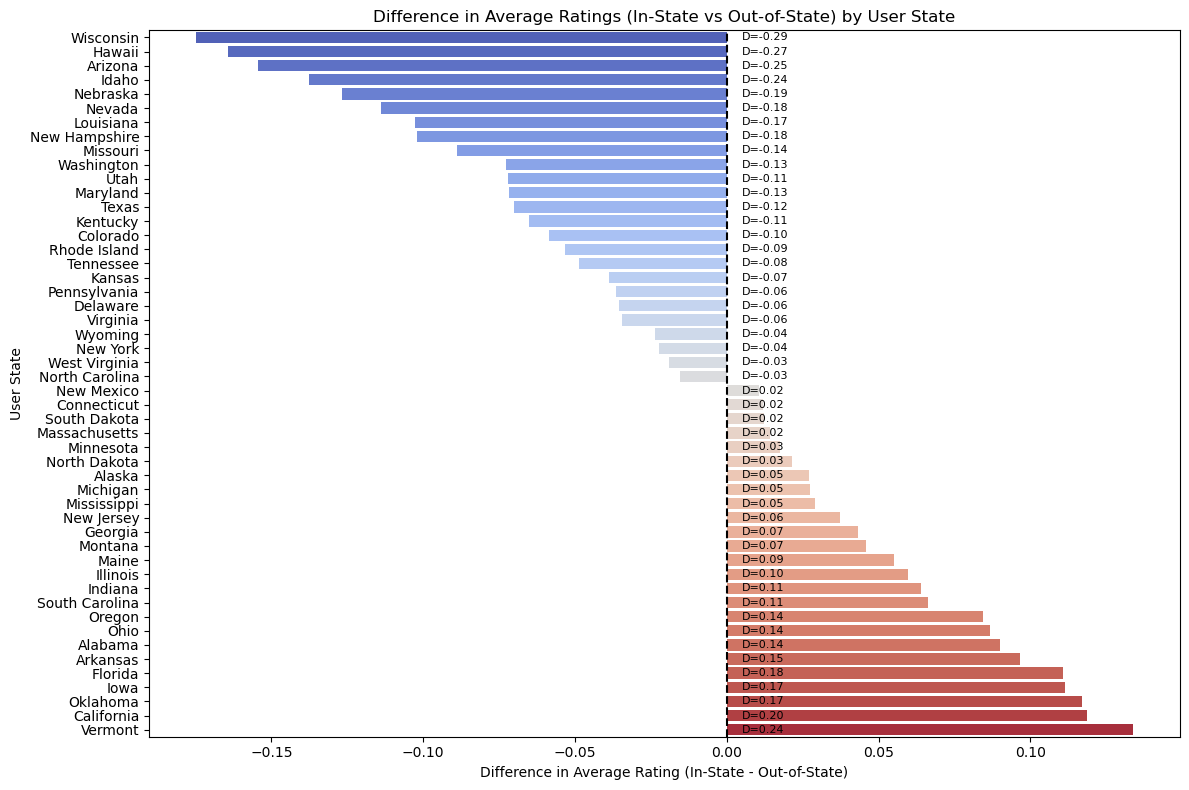

C:\Users\iaran\AppData\Local\Temp\ipykernel_14960\2191283091.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(data=filtered_results, y='state', x='difference', palette='coolwarm', orient='h')


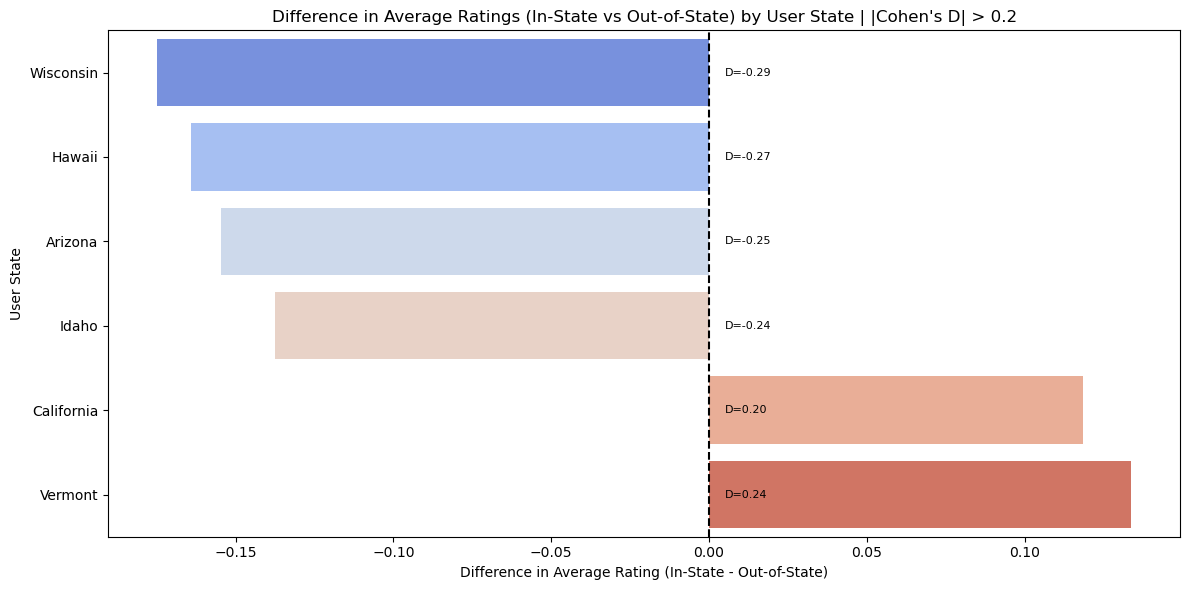

In [64]:
def cohen_d(x, y):
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    mean_x, mean_y = np.mean(x), np.mean(y)
    std_x, std_y = np.std(x, ddof=1), np.std(y, ddof=1)  # Using sample standard deviation
    pooled_std = np.sqrt(((nx - 1) * std_x ** 2 + (ny - 1) * std_y ** 2) / (nx + ny - 2))
    if pooled_std == 0:
        return np.nan
    return (mean_x - mean_y) / pooled_std

unique_states = US_ratings['user_state'].unique()

results = []

for state in unique_states:
    state_users = US_ratings[US_ratings['user_state'] == state].copy()
    
    if state_users.empty:
        continue
    
    state_users['beer_origin'] = np.where(
        state_users['beer_state'] == state, 
        'In-State Beer', 
        'Out-of-State Beer'
    )
    
    in_state_ratings = state_users[state_users['beer_origin'] == 'In-State Beer']['rating']
    out_of_state_ratings = state_users[state_users['beer_origin'] == 'Out-of-State Beer']['rating']
    
    if in_state_ratings.empty or out_of_state_ratings.empty:
        continue
    
    average_in_state = in_state_ratings.mean()
    average_out_of_state = out_of_state_ratings.mean()
    
    d_value = cohen_d(in_state_ratings, out_of_state_ratings)
    
    rating_diff = average_in_state - average_out_of_state
    
    results.append({
        'state': state,
        'average_in_state': average_in_state,
        'average_out_of_state': average_out_of_state,
        'difference': rating_diff,
        'cohen_d': d_value
    })

state_results = pd.DataFrame(results)
state_results.sort_values(by='difference', inplace=True)  # Sort by difference
state_results.reset_index(drop=True, inplace=True)

plt.figure(figsize=(12, 8))
ax = sns.barplot(data=state_results, y='state', x='difference', palette='coolwarm', orient='h')
plt.title("Difference in Average Ratings (In-State vs Out-of-State) by User State")
plt.ylabel("User State")
plt.xlabel("Difference in Average Rating (In-State - Out-of-State)")
plt.axvline(0, color='black', linestyle='--')

for i, row in state_results.iterrows():
    d_val = f"D={row['cohen_d']:.2f}" if not pd.isna(row['cohen_d']) else "D=NaN"
    text_x = 0.005  
    ax.text(text_x, i, d_val, 
            color='black', ha='left', va='center', fontsize=8, rotation=0)

plt.tight_layout()
plt.show()

filtered_results = state_results[abs(state_results['cohen_d']) > 0.2].copy()
filtered_results.sort_values(by='difference', inplace=True)
filtered_results.reset_index(drop=True, inplace=True)


plt.figure(figsize=(12, 6))
ax2 = sns.barplot(data=filtered_results, y='state', x='difference', palette='coolwarm', orient='h')
plt.title("Difference in Average Ratings (In-State vs Out-of-State) by User State | |Cohen's D| > 0.2")
plt.xlabel("Difference in Average Rating (In-State - Out-of-State)")
plt.ylabel("User State")
plt.axvline(0, color='black', linestyle='--')

for i, row in filtered_results.iterrows():
    d_val = f"D={row['cohen_d']:.2f}" if not pd.isna(row['cohen_d']) else "D=NaN"
    text_x = 0.005  
    ax2.text(text_x, i, d_val, 
             color='black', ha='left', va='center', fontsize=8, rotation=0)

plt.tight_layout()
plt.show()


In [ ]:
def cohen_d(x, y):
    x, y = np.array(x, dtype=float), np.array(y, dtype=float)
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    mean_x, mean_y = np.mean(x), np.mean(y)
    std_x, std_y = np.std(x, ddof=1), np.std(y, ddof=1)
    pooled_std = np.sqrt(((nx - 1) * std_x ** 2 + (ny - 1) * std_y ** 2) / (nx + ny - 2))
    if pooled_std == 0:
        return np.nan
    return (mean_x - mean_y) / pooled_std

threshold = 15000
beer_style_counts = US_ratings['style'].value_counts()
representative_beer_styles = beer_style_counts[beer_style_counts >= threshold].index

print(f"Beer styles with at least {threshold} reviews:")
print(representative_beer_styles)
print('shape:',representative_beer_styles.size)

filtered_ratings = US_ratings[US_ratings['style'].isin(representative_beer_styles)]

unique_states = filtered_ratings['beer_state'].unique()
unique_states.sort()

cohen_results_by_type = {}

for state in unique_states:
    for b_type in representative_beer_styles:
        subset = filtered_ratings[(filtered_ratings['beer_state'] == state) & (filtered_ratings['style'] == b_type)]
        in_state_ratings = subset[subset['state_IN_VS_OUT'] == 'In-State']['rating']
        out_of_state_ratings = subset[subset['state_IN_VS_OUT'] == 'Out-of-State']['rating']
        
        if len(in_state_ratings) < 2 or len(out_of_state_ratings) < 2:
            cohen_results_by_type[(state, b_type)] = np.nan
            continue
        
        d_value = cohen_d(in_state_ratings, out_of_state_ratings)
        cohen_results_by_type[(state, b_type)] = d_value

cohen_by_type_df = pd.DataFrame.from_dict(cohen_results_by_type, orient='index', columns=['Cohen_d'])
cohen_by_type_df.index = pd.MultiIndex.from_tuples(cohen_by_type_df.index, names=['State', 'Beer Type'])
cohen_by_type_df = cohen_by_type_df.reset_index()

cohen_by_type_df_no_nan = cohen_by_type_df.dropna(subset=['Cohen_d'])




In [ ]:
heatmap_data = cohen_by_type_df_no_nan.pivot(index='State', columns='Beer Type', values='Cohen_d')

plt.figure(figsize=(20, 14))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=False, fmt=".2f", cbar_kws={'label': "Cohen's D"})
plt.title("Cohen’s D by State and Beer Type")
plt.xlabel("Beer Type")
plt.ylabel("State")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()